In [1]:
'''这里是cpu版本运行的，改成gpu版只需将注释中的cuda取消注释即可；cpu只是运行了近9个小时，可算是很浅的网络了；
Reference:
https://blog.csdn.net/randompeople/article/details/90616164
'''


from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
import pandas as pd
from bs4 import BeautifulSoup
import itertools
import more_itertools
import numpy as np
import pickle


In [2]:
# device

In [3]:
## The dataset is taken from https://github.com/justmarkham/DAT7/blob/master/data/yelp.csv 
df=pd.read_csv('../DataSets/yelp.csv')

In [4]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [5]:
## mark the columns which contains text for classification and target class
col_text = 'text'
col_target = 'cool'

In [6]:
cls_arr = np.sort(df[col_target].unique()).tolist()
classes = len(cls_arr)

In [7]:
## divide dataset in 80% train 10% validation 10% test as done in the paper
length = df.shape[0]
train_len = int(0.8*length)
val_len = int(0.1*length)

In [8]:
train = df[:train_len]
val = df[train_len:train_len+val_len]
test = df[train_len+val_len:]

In [9]:
def clean_str(string, max_seq_len):
    """
    adapted from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = BeautifulSoup(string, "lxml").text
    string = re.sub(r"[^A-Za-z0-9(),!?\"\`]", " ", string)
    string = re.sub(r"\"s", " \"s", string)
    string = re.sub(r"\"ve", " \"ve", string)
    string = re.sub(r"n\"t", " n\"t", string)
    string = re.sub(r"\"re", " \"re", string)
    string = re.sub(r"\"d", " \"d", string)
    string = re.sub(r"\"ll", " \"ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    s =string.strip().lower().split(" ")
    if len(s) > max_seq_len:
        return s[0:max_seq_len] 
    return s

In [10]:
## creates a 3D list of format paragraph[sentence[word]]
def create3DList(df,col, max_sent_len,max_seq_len):
    x=[]
    for docs in df[col].as_matrix():
        x1=[]
        idx = 0
        for seq in "|||".join(re.split("[.?!]", docs)).split("|||"):
            x1.append(clean_str(seq,max_sent_len))
            if(idx>=max_seq_len-1):
                break
            idx= idx+1
        x.append(x1)
    return x

In [11]:
## Fix the maximum length of sentences in a paragraph and words in a sentence
max_sent_len = 12
max_seq_len = 25

In [12]:
## divides review in sentences and sentences into word creating a 3DList
x_train = create3DList(train,col_text, max_sent_len,max_seq_len)
x_val = create3DList(val, col_text, max_sent_len,max_seq_len)
x_test = create3DList(test, col_text, max_sent_len,max_seq_len)
print("x_train: {}".format(len(x_train)))
print("x_val: {}".format(len(x_val)))
print("x_test: {}".format(len(x_test)))

/home/jesse/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/home/jesse/anaconda3/envs/py36/lib/python3.6/site-packages/bs4/__init__.py:272: UserWarning: "b'/'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/jesse/anaconda3/envs/py36/lib/python3.6/site-packages/bs4/__init__.py:335: UserWarning: "http://stevelerer" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/home/jesse/anaconda3/envs/py36/lib/python3.6/site-packages/bs4/__init__.py:335: UserWarning: "http://www" looks like a URL. Beautiful Soup is not an HTTP client. You should probabl

x_train: 8000
x_val: 1000
x_test: 1000


In [13]:
from gensim.models import Word2Vec
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jesse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
stoplist = stopwords.words('english') + list(string.punctuation)
stemmer = SnowballStemmer('english')
x_train_texts = [[[stemmer.stem(word.lower()) for word in sent  if word not in stoplist] for sent in para]
         for para in x_train]
x_test_texts = [[[stemmer.stem(word.lower()) for word in sent  if word not in stoplist] for sent in para]
         for para in x_test]
x_val_texts = [[[stemmer.stem(word.lower()) for word in sent  if word not in stoplist] for sent in para]
         for para in x_val]

## calculate frequency of words
from collections import defaultdict
frequency1 = defaultdict(int)
for texts in x_train_texts:     
    for text in texts:
        for token in text:
            frequency1[token] += 1
for texts in x_test_texts:     
    for text in texts:
        for token in text:
            frequency1[token] += 1
for texts in x_val_texts:     
    for text in texts:
        for token in text:
            frequency1[token] += 1
            
## remove  words with frequency less than 5.
x_train_texts = [[[token for token in text if frequency1[token] > 5]
         for text in texts] for texts in x_train_texts]

x_test_texts = [[[token for token in text if frequency1[token] > 5]
         for text in texts] for texts in x_test_texts]
x_val_texts = [[[token for token in text if frequency1[token] > 5]
         for text in texts] for texts in x_val_texts]

In [15]:
texts = list(more_itertools.collapse(x_train_texts[:] + x_test_texts[:] + x_val_texts[:],levels=1))

In [16]:
## train word2vec model on all the words
word2vec = Word2Vec(texts,size=200, min_count=5)

In [17]:
word2vec.save("../OutPut/dictonary_yelp")

In [18]:
## convert 3D text list to 3D list of index 
x_train_vec = [[[word2vec.wv.vocab[token].index for token in text]
         for text in texts] for texts in x_train_texts]

In [19]:
x_test_vec = [[[word2vec.wv.vocab[token].index for token in text]
         for text in texts] for texts in x_test_texts]

In [20]:
x_val_vec = [[[word2vec.wv.vocab[token].index for token in text]
         for text in texts] for texts in x_val_texts]

In [21]:
weights = torch.FloatTensor(word2vec.wv.syn0)#.cuda()

/home/jesse/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [22]:
vocab_size = len(word2vec.wv.vocab)

In [23]:
y_train = train[col_target].tolist()
y_test = test[col_target].tolist()
y_val = val[col_target].tolist()

In [24]:
## Make the the multiple attention with word vectors.
def attention_mul(rnn_outputs, att_weights):
    attn_vectors = None
    for i in range(rnn_outputs.size(0)):
        h_i = rnn_outputs[i]
        a_i = att_weights[i]
        h_i = a_i * h_i
        h_i = h_i.unsqueeze(0)
        if(attn_vectors is None):
            attn_vectors = h_i
        else:
            attn_vectors = torch.cat((attn_vectors,h_i),0)
    return torch.sum(attn_vectors, 0).unsqueeze(0)

In [25]:
## The word RNN model for generating a sentence vector
class WordRNN(nn.Module):
    def __init__(self, vocab_size,embedsize, batch_size, hid_size):
        super(WordRNN, self).__init__()
        self.batch_size = batch_size
        self.embedsize = embedsize
        self.hid_size = hid_size
        ## Word Encoder
        self.embed = nn.Embedding(vocab_size, embedsize)
        self.wordRNN = nn.GRU(embedsize, hid_size, bidirectional=True)
        ## Word Attention
        self.wordattn = nn.Linear(2*hid_size, 2*hid_size)
        self.attn_combine = nn.Linear(2*hid_size, 2*hid_size,bias=False)
    def forward(self,inp, hid_state):
        emb_out  = self.embed(inp)

        out_state, hid_state = self.wordRNN(emb_out, hid_state)

        word_annotation = self.wordattn(out_state)
        attn = F.softmax(self.attn_combine(word_annotation),dim=1)

        sent = attention_mul(out_state,attn)
        return sent, hid_state


In [26]:
## The HAN model
class SentenceRNN(nn.Module):
    def __init__(self,vocab_size,embedsize, batch_size, hid_size,c):
        super(SentenceRNN, self).__init__()
        self.batch_size = batch_size
        self.embedsize = embedsize
        self.hid_size = hid_size
        self.cls = c
        self.wordRNN = WordRNN(vocab_size,embedsize, batch_size, hid_size)
        ## Sentence Encoder
        self.sentRNN = nn.GRU(embedsize, hid_size, bidirectional=True)
        ## Sentence Attention
        self.sentattn = nn.Linear(2*hid_size, 2*hid_size)
        self.attn_combine = nn.Linear(2*hid_size, 2*hid_size,bias=False)
        self.doc_linear = nn.Linear(2*hid_size, c)
    
    def forward(self,inp, hid_state_sent, hid_state_word):
        s = None
        ## Generating sentence vector through WordRNN
        for i in range(len(inp[0])):
            r = None
            for j in range(len(inp)):
                if(r is None):
                    r = [inp[j][i]]
                else:
                    r.append(inp[j][i])
            r1 = np.asarray([sub_list + [0] * (max_seq_len - len(sub_list)) for sub_list in r])
            _s, state_word = self.wordRNN(torch.LongTensor(r1).view(-1,batch_size), hid_state_word)  # torch.cuda.LongTensor
            if(s is None):
                s = _s
            else:
                s = torch.cat((s,_s),0)

                out_state, hid_state = self.sentRNN(s, hid_state_sent)
        sent_annotation = self.sentattn(out_state)
        attn = F.softmax(self.attn_combine(sent_annotation),dim=1)

        doc = attention_mul(out_state,attn)
        d = self.doc_linear(doc)
        cls = F.log_softmax(d.view(-1,self.cls),dim=1)
        return cls, hid_state
    
    def init_hidden_sent(self):
            return Variable(torch.zeros(2, self.batch_size, self.hid_size))#.cuda()
    
    def init_hidden_word(self):
            return Variable(torch.zeros(2, self.batch_size, self.hid_size))#.cuda()


In [27]:
## converting list to tensor
y_train_tensor =  [torch.FloatTensor([cls_arr.index(label)]) for label in y_train]  # torch.cuda.FloatTensor
y_val_tensor =  [torch.FloatTensor([cls_arr.index(label)]) for label in y_val]  # torch.cuda.FloatTensor
y_test_tensor =  [torch.FloatTensor([cls_arr.index(label)]) for label in y_test]  # torch.cuda.FloatTensor

In [28]:
max_seq_len = max([len(seq) for seq in itertools.chain.from_iterable(x_train_vec +x_val_vec + x_test_vec)])
max_sent_len = max([len(sent) for sent in (x_train_vec + x_val_vec + x_test_vec)])

In [29]:
max_seq_len

12

In [30]:
max_sent_len

25

In [31]:
np.percentile(np.array([len(seq) for seq in itertools.chain.from_iterable(x_train_vec +x_val_vec + x_test_vec)]),90)

6.0

In [32]:
np.percentile(np.array([len(sent) for sent in (x_train_vec +x_val_vec + x_test_vec)]),90)

25.0

In [33]:
## Padding the input 
X_train_pad = [sub_list + [[0]] * (max_sent_len - len(sub_list)) for sub_list in x_train_vec]
X_val_pad = [sub_list + [[0]] * (max_sent_len - len(sub_list)) for sub_list in x_val_vec]
X_test_pad = [sub_list + [[0]] * (max_sent_len - len(sub_list)) for sub_list in x_test_vec]

In [34]:
batch_size = 64

In [45]:
def train_data(batch_size, review, targets, sent_attn_model, sent_optimizer, criterion):

    state_word = sent_attn_model.init_hidden_word()
    state_sent = sent_attn_model.init_hidden_sent()
    sent_optimizer.zero_grad()
            
    y_pred, state_sent = sent_attn_model(review, state_sent, state_word)

    loss = criterion(y_pred, torch.LongTensor(targets))   # y_pred.cuda()\torch.cuda.LongTensor

    max_index = y_pred.max(dim = 1)[1]
    correct = (max_index == torch.LongTensor(targets)).sum()  # torch.cuda.LongTensor
    acc = float(correct)/batch_size

    loss.backward()
    
    sent_optimizer.step()
    
    return loss.item(),acc

In [46]:
hid_size = 100
embedsize = 200 

In [47]:
sent_attn = SentenceRNN(vocab_size,embedsize,batch_size,hid_size,classes)
#sent_attn.cuda()
sent_attn.wordRNN.embed.from_pretrained(weights)
torch.backends.cudnn.benchmark=True

In [48]:
learning_rate = 1e-3
momentum = 0.9

sent_optimizer = torch.optim.SGD(sent_attn.parameters(), lr=learning_rate, momentum= momentum)

criterion = nn.NLLLoss()

In [49]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [50]:
def gen_batch(x,y,batch_size):
    k = random.sample(range(len(x)-1),batch_size)
    x_batch=[]
    y_batch=[]

    for t in k:
        x_batch.append(x[t])
        y_batch.append(y[t])

    return [x_batch,y_batch]

In [51]:
def validation_accuracy(batch_size, x_val,y_val,sent_attn_model):
    acc = []
    val_length = len(x_val)
    for j in range(int(val_length/batch_size)):
        x,y = gen_batch(x_val,y_val,batch_size)
        state_word = sent_attn_model.init_hidden_word()
        state_sent = sent_attn_model.init_hidden_sent()
        
        y_pred, state_sent = sent_attn_model(x, state_sent, state_word)
        max_index = y_pred.max(dim = 1)[1]
        correct = (max_index == torch.LongTensor(y)).sum()  # torch.cuda.LongTensor
        acc.append(float(correct)/batch_size)
    return np.mean(acc)

In [52]:
def train_early_stopping(batch_size, x_train, y_train, x_val, y_val, sent_attn_model, 
                         sent_attn_optimiser, loss_criterion, num_epoch,
                         print_loss_every = 50, code_test=True):
    start = time.time()
    loss_full = []
    loss_epoch = []
    acc_epoch = []
    acc_full = []
    val_acc = []
    epoch_counter = 0
    train_length = len(x_train)
    for i in range(1, num_epoch + 1):
        loss_epoch = []
        acc_epoch = []
        for j in range(int(train_length/batch_size)):
            x,y = gen_batch(x_train,y_train,batch_size)
            loss,acc = train_data(batch_size, x, y, sent_attn_model, sent_attn_optimiser, loss_criterion)
            loss_epoch.append(loss)
            acc_epoch.append(acc)
            if (code_test and j % int(print_loss_every/batch_size) == 0) :
                print ('Loss at %d paragraphs, %d epoch,(%s) is %f' %(j*batch_size, i, timeSince(start), np.mean(loss_epoch)))
                print ('Accuracy at %d paragraphs, %d epoch,(%s) is %f' %(j*batch_size, i, timeSince(start), np.mean(acc_epoch)))
        
        loss_full.append(np.mean(loss_epoch))
        acc_full.append(np.mean(acc_epoch))
        torch.save(sent_attn_model.state_dict(), '../OutPut/sent_attn_model_yelp.pth')
        print ('Loss after %d epoch,(%s) is %f' %(i, timeSince(start), np.mean(loss_epoch)))
        print ('Train Accuracy after %d epoch,(%s) is %f' %(i, timeSince(start), np.mean(acc_epoch)))

        val_acc.append(validation_accuracy(batch_size, x_val, y_val, sent_attn_model)) 
        print ('Validation Accuracy after %d epoch,(%s) is %f' %(i, timeSince(start), val_acc[-1]))
    return loss_full,acc_full,val_acc


In [53]:
epoch = 200  # 电脑配置所限，有cuda情况下可以设置1000次

In [54]:
loss_full, acc_full, val_acc = train_early_stopping(batch_size, X_train_pad, y_train_tensor, X_val_pad,
                                y_val_tensor, sent_attn, sent_optimizer, criterion, epoch, 10000, False)

Loss after 1 epoch,(2m 12s) is 3.123740
Train Accuracy after 1 epoch,(2m 12s) is 0.496875
Validation Accuracy after 1 epoch,(2m 19s) is 0.622917
Loss after 2 epoch,(4m 20s) is 2.392077
Train Accuracy after 2 epoch,(4m 20s) is 0.624000
Validation Accuracy after 2 epoch,(4m 26s) is 0.636458
Loss after 3 epoch,(6m 33s) is 1.768327
Train Accuracy after 3 epoch,(6m 33s) is 0.630875
Validation Accuracy after 3 epoch,(6m 40s) is 0.621875
Loss after 4 epoch,(8m 54s) is 1.574723
Train Accuracy after 4 epoch,(8m 54s) is 0.623500
Validation Accuracy after 4 epoch,(9m 1s) is 0.620833
Loss after 5 epoch,(11m 30s) is 1.475871
Train Accuracy after 5 epoch,(11m 30s) is 0.620250
Validation Accuracy after 5 epoch,(11m 36s) is 0.650000
Loss after 6 epoch,(13m 50s) is 1.395327
Train Accuracy after 6 epoch,(13m 50s) is 0.627000
Validation Accuracy after 6 epoch,(13m 57s) is 0.637500
Loss after 7 epoch,(16m 18s) is 1.343191
Train Accuracy after 7 epoch,(16m 18s) is 0.630000
Validation Accuracy after 7 epoch

Validation Accuracy after 55 epoch,(123m 15s) is 0.609375
Loss after 56 epoch,(125m 16s) is 1.222557
Train Accuracy after 56 epoch,(125m 16s) is 0.631750
Validation Accuracy after 56 epoch,(125m 23s) is 0.634375
Loss after 57 epoch,(127m 23s) is 1.225559
Train Accuracy after 57 epoch,(127m 23s) is 0.635625
Validation Accuracy after 57 epoch,(127m 29s) is 0.626042
Loss after 58 epoch,(129m 29s) is 1.219670
Train Accuracy after 58 epoch,(129m 29s) is 0.631750
Validation Accuracy after 58 epoch,(129m 35s) is 0.638542
Loss after 59 epoch,(131m 36s) is 1.225270
Train Accuracy after 59 epoch,(131m 36s) is 0.636750
Validation Accuracy after 59 epoch,(131m 43s) is 0.638542
Loss after 60 epoch,(133m 41s) is 1.258781
Train Accuracy after 60 epoch,(133m 41s) is 0.622000
Validation Accuracy after 60 epoch,(133m 48s) is 0.679167
Loss after 61 epoch,(135m 48s) is 1.238783
Train Accuracy after 61 epoch,(135m 48s) is 0.633250
Validation Accuracy after 61 epoch,(135m 54s) is 0.627083
Loss after 62 epoc

Loss after 109 epoch,(237m 23s) is 1.209324
Train Accuracy after 109 epoch,(237m 23s) is 0.633250
Validation Accuracy after 109 epoch,(237m 29s) is 0.655208
Loss after 110 epoch,(239m 31s) is 1.223175
Train Accuracy after 110 epoch,(239m 31s) is 0.634750
Validation Accuracy after 110 epoch,(239m 37s) is 0.628125
Loss after 111 epoch,(241m 36s) is 1.248701
Train Accuracy after 111 epoch,(241m 36s) is 0.622750
Validation Accuracy after 111 epoch,(241m 42s) is 0.633333
Loss after 112 epoch,(243m 43s) is 1.234984
Train Accuracy after 112 epoch,(243m 43s) is 0.624250
Validation Accuracy after 112 epoch,(243m 49s) is 0.609375
Loss after 113 epoch,(245m 51s) is 1.231296
Train Accuracy after 113 epoch,(245m 51s) is 0.630625
Validation Accuracy after 113 epoch,(245m 57s) is 0.640625
Loss after 114 epoch,(247m 58s) is 1.254878
Train Accuracy after 114 epoch,(247m 58s) is 0.623375
Validation Accuracy after 114 epoch,(248m 5s) is 0.651042
Loss after 115 epoch,(250m 6s) is 1.283192
Train Accuracy a

Validation Accuracy after 161 epoch,(347m 10s) is 0.615625
Loss after 162 epoch,(349m 9s) is 1.210737
Train Accuracy after 162 epoch,(349m 9s) is 0.636125
Validation Accuracy after 162 epoch,(349m 16s) is 0.652083
Loss after 163 epoch,(351m 16s) is 1.250711
Train Accuracy after 163 epoch,(351m 16s) is 0.626000
Validation Accuracy after 163 epoch,(351m 22s) is 0.629167
Loss after 164 epoch,(353m 22s) is 1.233094
Train Accuracy after 164 epoch,(353m 22s) is 0.631125
Validation Accuracy after 164 epoch,(353m 28s) is 0.632292
Loss after 165 epoch,(355m 29s) is 1.266046
Train Accuracy after 165 epoch,(355m 29s) is 0.613750
Validation Accuracy after 165 epoch,(355m 35s) is 0.613542
Loss after 166 epoch,(357m 35s) is 1.236722
Train Accuracy after 166 epoch,(357m 35s) is 0.628250
Validation Accuracy after 166 epoch,(357m 42s) is 0.639583
Loss after 167 epoch,(359m 42s) is 1.219021
Train Accuracy after 167 epoch,(359m 42s) is 0.632250
Validation Accuracy after 167 epoch,(359m 48s) is 0.633333
L

In [55]:
import matplotlib.pyplot as plt
plt.plot(loss_full)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.savefig('../OutPut/loss.png')

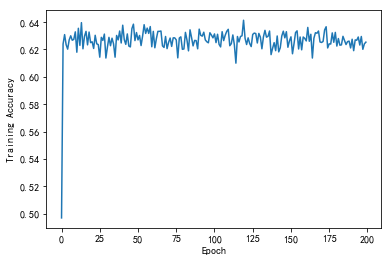

In [56]:
plt.plot(acc_full)
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.savefig('../OutPut/train_acc.png')

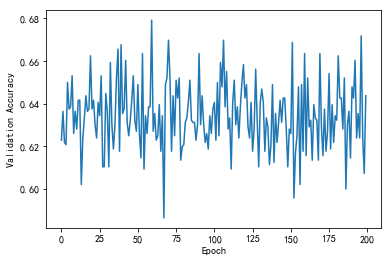

In [57]:
plt.plot(val_acc)
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.savefig('../OutPut/val_acc.png')

In [58]:
def test_accuracy(batch_size, x_test, y_test, sent_attn_model):
    acc = []
    test_length = len(x_test)
    for j in range(int(test_length/batch_size)):
        x,y = gen_batch(x_test,y_test,batch_size)
        state_word = sent_attn_model.init_hidden_word()
        state_sent = sent_attn_model.init_hidden_sent()
        
        y_pred, state_sent = sent_attn_model(x, state_sent, state_word)
        max_index = y_pred.max(dim = 1)[1]
        correct = (max_index == torch.LongTensor(y)).sum()  # torch.cuda.LongTensor
        acc.append(float(correct)/batch_size)
    return np.mean(acc)

In [59]:
test_accuracy(batch_size, X_test_pad, y_test_tensor, sent_attn)

0.6302083333333334